In [1]:
import torch
import matplotlib.pyplot as plt
import math
torch.manual_seed(101)

In [2]:
# Bayesian Linear Regression
n = 100
x = torch.concat([torch.linspace(-math.pi * 3 / 4, -math.pi / 4, n // 2), torch.linspace(math.pi / 4, math.pi * 3 / 4, n // 2)])
noise_std = torch.tensor(0.1)
y_val = 2 * torch.sin(x)
y_obs = y_val + torch.randn(x.size()) * noise_std

x = x.unsqueeze(-1)
y_obs = y_obs.unsqueeze(-1)

n_test = 150
x_test = torch.linspace(-math.pi, math.pi, n_test)

In [3]:
# VI procedure
import metrics
import models
from posteriors import VIFOSingleExp, VIFFGModel

model_cfg = models.MLP
model_cfg.kwargs['in_dim'] = 1
model_cfg.kwargs['layers'] = 5
model_args = list()
prior_var = 0.1
cfg = {'alpha_reg': 0.05, 'gamma': 0.3}
L = 5
beta = 0.1

In [4]:
def compute_extra_reg(model, x_extra):
    _, kl_extra = model(L, x_extra, reg=True)
    return kl_extra

Producing Figure 1:

In [5]:
# Without auxiliary training.
model_no_aug = VIFOSingleExp(model_cfg.base, 0.1, 'mean', cfg, *model_args, **model_cfg.kwargs)
criterion = metrics.ELBO(n, normalize=False)
optimizer = torch.optim.Adam(model_no_aug.parameters(), lr=0.001)
x_extra = x_test.unsqueeze(-1)
for i in range(1500):
    optimizer.zero_grad()
    outputs, kl = model_no_aug(L, x, reg=True)
    loss = criterion(outputs, y_obs, kl, beta, regression=True)
    loss.backward()
    optimizer.step()

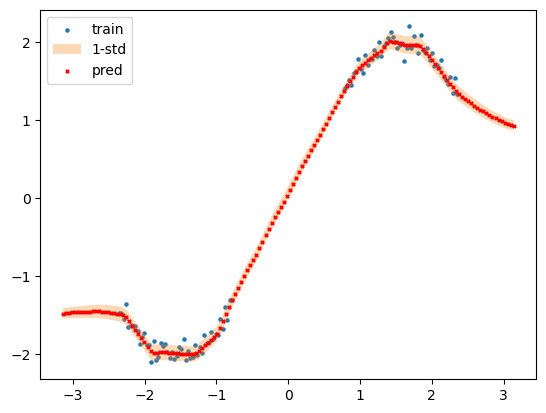

In [6]:
# process output
with torch.no_grad():
    mean, sigma = model_no_aug.get_mean_sigma(x_test.unsqueeze(-1))
    var = sigma ** 2
    y_mean = mean[:, 0]
    alea_var = torch.exp(mean[:, 1])
    total_var = torch.sqrt(var[:, 0] + torch.exp(mean[:, 1] + var[:, 1] / 2))
    plt.figure()
    plt.scatter(x, y_obs, label='train', s=5)
    plt.fill_between(x_test, y_mean - total_var, y_mean + total_var, alpha=0.3, label='1-std')
    plt.scatter(x_test, y_mean, marker='x', label='pred', s=5, color='red')
    plt.legend(loc='best')
    plt.show()

In [7]:
model_aug = VIFOSingleExp(model_cfg.base, 0.1, 'mean', cfg, *model_args, **model_cfg.kwargs)
criterion = metrics.ELBO(n, normalize=False)
optimizer = torch.optim.Adam(model_aug.parameters(), lr=0.001)
x_extra = x_test.unsqueeze(-1)
for i in range(1500):
    optimizer.zero_grad()
    outputs, kl = model_aug(L, x, reg=True)
    loss = criterion(outputs, y_obs, kl, beta, regression=True)
    reg_extra = compute_extra_reg(model_aug, x_extra)
    loss += reg_extra
    loss.backward()
    optimizer.step()

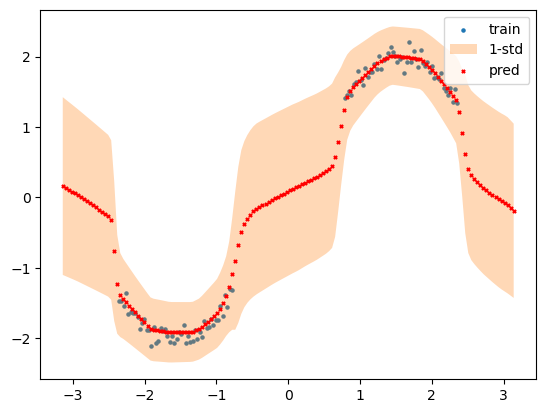

In [8]:
# process output
with torch.no_grad():
    mean, sigma = model_aug.get_mean_sigma(x_test.unsqueeze(-1))
    var = sigma ** 2
    y_mean = mean[:, 0]
    alea_var = torch.exp(mean[:, 1])
    total_var = torch.sqrt(var[:, 0] + torch.exp(mean[:, 1] + var[:, 1] / 2))
    plt.figure()
    plt.scatter(x, y_obs, label='train', s=5)
    plt.fill_between(x_test, y_mean - total_var, y_mean + total_var, alpha=0.3, label='1-std')
    plt.scatter(x_test, y_mean, marker='x', label='pred', s=5, color='red')
    plt.legend(loc='best')
    plt.show()

Produce Figure 2, comparing the prior distribution

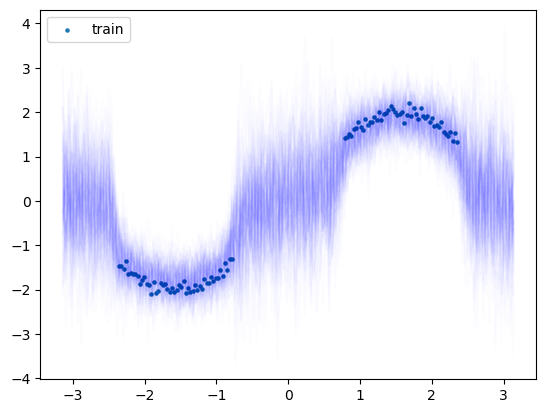

In [9]:
# plot the resulting prior
with torch.no_grad():
    mu_q, s_q = model_aug.get_mean_sigma(x_test.unsqueeze(-1))
    mu_p_mean = (1 - cfg['alpha_reg']) * mu_q
    mu_p_var = torch.tensor(cfg['gamma'] * cfg['alpha_reg'])
    plt.figure()
    for _ in range(100):
        eps = torch.randn_like(mu_q)
        mu_p = eps * torch.sqrt(mu_p_var) + mu_p_mean
        x_mean = mu_p[:, 0]
        x_var = torch.exp(mu_p[:, 1])
        eps_x = torch.randn_like(x_mean)
        y = x_mean + torch.sqrt(x_var) * eps_x
        plt.plot(x_test, y, alpha=0.01, color='blue')
    plt.scatter(x, y_obs, label='train', s=5)
    plt.legend(loc='best')
    plt.show()

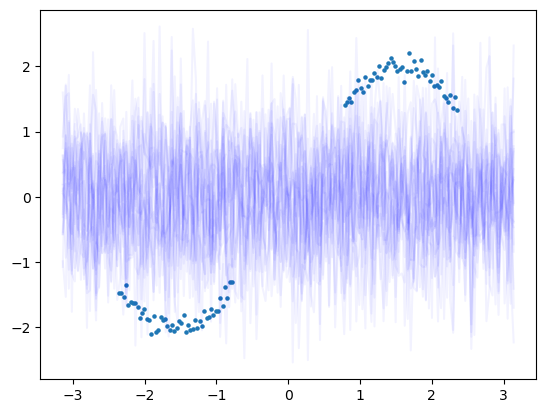

In [10]:
# VI prior 
fixed_priors = {'prior_mu': 0., 'prior_sigma': 1.0, 'posterior_mu_initial': (0., 0.0), 'posterior_rho_initial': (-4, 0.0)}
vi_model = VIFFGModel(model_cfg.base, fixed_priors, 'naive', cfg, *model_args, **model_cfg.kwargs)
plt.figure()
with torch.no_grad():
    L_test = 100
    output = vi_model(L_test, x_test.unsqueeze(-1))
    for i in range(20):
        x_mean = output[i, :, 0]
        x_var = torch.nn.functional.softplus(output[i, :, 1])
        eps_x = torch.randn_like(x_mean)
        y = x_mean + torch.sqrt(x_var) * eps_x
        plt.plot(x_test, y, alpha=0.05, color='blue')
    plt.scatter(x, y_obs, label='train', s=5)
    plt.show()

In [11]:
# VI model
priors = {'prior_mu': 0., 'prior_sigma': 1.0, 'posterior_mu_initial': (0., 0.1), 'posterior_rho_initial': (-4, 0.1)}
vi_model = VIFFGModel(model_cfg.base, priors, 'mean', cfg, *model_args, **model_cfg.kwargs)
vi_criterion = metrics.ELBO(n, normalize=True)
optimizer = torch.optim.Adam(vi_model.parameters(), lr=0.005)
best_model_state_dict = None
for i in range(1500):
    optimizer.zero_grad()
    outputs = vi_model(L, x)
    kl = vi_model.compute_reg()
    loss = vi_criterion(outputs, y_obs, kl, 0.1, regression=True)
    loss.backward()
    optimizer.step()

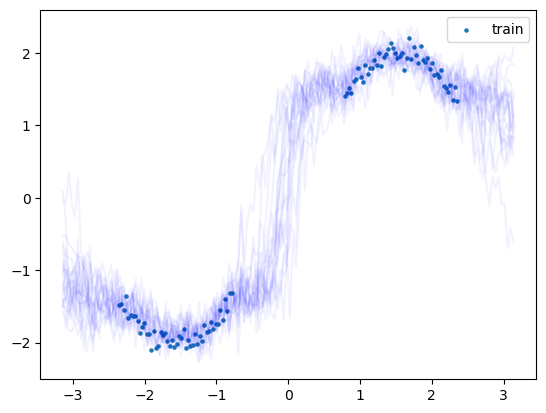

In [12]:
plt.figure()
with torch.no_grad():
    L_test = 100
    output = vi_model(L_test, x_test.unsqueeze(-1))
    for i in range(20):
        x_mean = output[i, :, 0]
        x_var = torch.nn.functional.softplus(output[i, :, 1])
        eps_x = torch.randn_like(x_mean)
        y = x_mean + torch.sqrt(x_var) * eps_x
        plt.plot(x_test, y, alpha=0.05, color='blue')
    plt.scatter(x, y_obs, label='train', s=5)
    plt.legend(loc='best')
    plt.show()